### Assignment 2
Kruthi : PES1UG20CS220
Anshula Aithal : PES1UG20CS064
Attili Krishna Kireeti : PES1UG20CS090



In [ ]:
!pip install gensim
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095428 sha256=7e184f756dd262b0d8e71db63c6b183b023e2bc65b62dce281318e0b9ea7fc8b
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
import surprise
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from scipy.stats import gamma
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from math import sqrt

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
df = pd.read_csv("https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Grocery_v1_00.tsv.gz", delimiter='\t', error_bad_lines=False)
df = df.head(10000)

<ipython-input-13-8050ec3252a9>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Grocery_v1_00.tsv.gz", delimiter='\t', error_bad_lines=False)
Skipping line 1925: expected 15 fields, saw 22
Skipping line 1977: expected 15 fields, saw 22
Skipping line 35265: expected 15 fields, saw 22
Skipping line 53357: expected 15 fields, saw 22

Skipping line 68361: expected 15 fields, saw 22
Skipping line 70922: expected 15 fields, saw 22
Skipping line 73503: expected 15 fields, saw 22
Skipping line 85612: expected 15 fields, saw 22
Skipping line 102322: expected 15 fields, saw 22

Skipping line 158341: expected 15 fields, saw 22
Skipping line 162872: expected 15 fields, saw 22
Skipping line 195697: expected 15 fields, saw 22

Skipping line 202916: expected 15 fields, saw 22
Skipping line 203949: expected 15 fields, saw 22

#**EDA**

In [ ]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,42521656,R26MV8D0KG6QI6,B000SAQCWC,159713740,"The Cravings Place Chocolate Chunk Cookie Mix,...",Grocery,5,0.0,0.0,N,Y,Using these for years - love them.,"As a family allergic to wheat, dairy, eggs, nu...",2015-08-31
1,US,12049833,R1OF8GP57AQ1A0,B00509LVIQ,138680402,"Mauna Loa Macadamias, 11 Ounce Packages",Grocery,5,0.0,0.0,N,Y,Wonderful,"My favorite nut. Creamy, crunchy, salty, and ...",2015-08-31
2,US,107642,R3VDC1QB6MC4ZZ,B00KHXESLC,252021703,Organic Matcha Green Tea Powder - 100% Pure Ma...,Grocery,5,0.0,0.0,N,N,Five Stars,This green tea tastes so good! My girlfriend l...,2015-08-31
3,US,6042304,R12FA3DCF8F9ER,B000F8JIIC,752728342,15oz Raspberry Lyons Designer Dessert Syrup Sauce,Grocery,5,0.0,0.0,N,Y,Five Stars,I love Melissa's brand but this is a great sec...,2015-08-31
4,US,18123821,RTWHVNV6X4CNJ,B004ZWR9RQ,552138758,"Stride Spark Kinetic Fruit Sugar Free Gum, 14-...",Grocery,5,0.0,0.0,N,Y,Five Stars,good,2015-08-31


In [ ]:
df.shape

(10000, 15)

In [ ]:
df.dtypes

marketplace           object
customer_id            int64
review_id             object
product_id            object
product_parent         int64
product_title         object
product_category      object
star_rating           object
helpful_votes        float64
total_votes          float64
vine                  object
verified_purchase     object
review_headline       object
review_body           object
review_date           object
dtype: object

In [ ]:
print(df.isna().sum())

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          2
review_date          0
dtype: int64


In [ ]:
print(df.duplicated().sum())

0


In [ ]:
df['customer_id'].nunique()

7918

In [ ]:
df['product_id'].nunique()

7919

        customer_id  product_parent  helpful_votes   total_votes
count  1.000000e+04    1.000000e+04   10000.000000  10000.000000
mean   2.708591e+07    4.984227e+08       0.665900      0.869700
std    1.597098e+07    2.860739e+08       4.704157      5.174186
min    1.987700e+04    2.079700e+04       0.000000      0.000000
25%    1.390580e+07    2.571054e+08       0.000000      0.000000
50%    2.566684e+07    4.997653e+08       0.000000      0.000000
75%    4.206221e+07    7.388834e+08       0.000000      1.000000
max    5.309495e+07    9.996552e+08     262.000000    274.000000


'\nNote:\nonly note the star rating, helpful votes and total votes. \n'

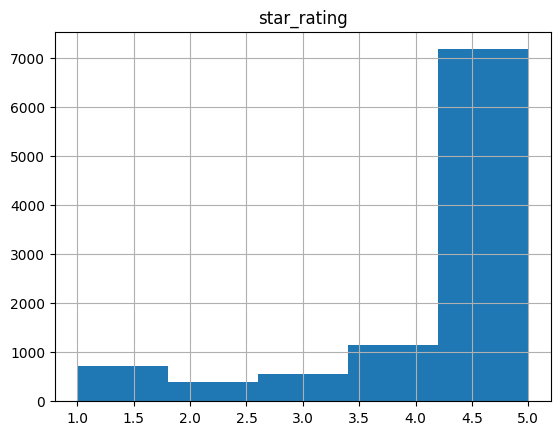

In [ ]:
#Star rating histogram
print(df.describe())
df = df.dropna(subset=['star_rating'])
df['star_rating'] = pd.to_numeric(df['star_rating'], errors='coerce')
df.hist(column='star_rating', bins=5)
'''
Note:
only note the star rating, helpful votes and total votes. 
'''

Grocery    10000
Name: product_category, dtype: int64


<Axes: >

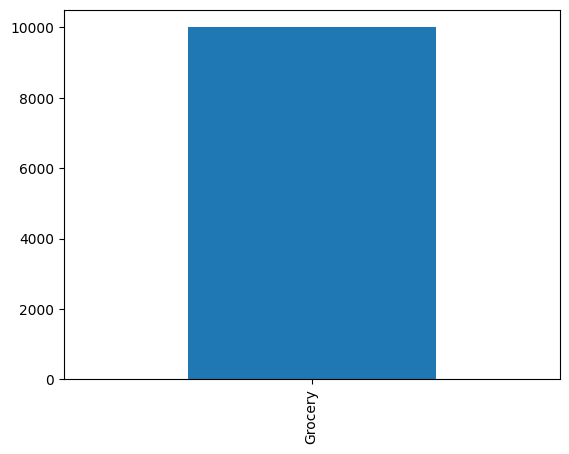

In [ ]:
#Product Category bar graph
print(df['product_category'].value_counts())
df['product_category'].value_counts().plot(kind='bar')

                customer_id  product_parent  star_rating  helpful_votes  \
customer_id        1.000000       -0.000750    -0.004756       0.010630   
product_parent    -0.000750        1.000000     0.006327      -0.005495   
star_rating       -0.004756        0.006327     1.000000      -0.078549   
helpful_votes      0.010630       -0.005495    -0.078549       1.000000   
total_votes        0.009480       -0.002349    -0.116607       0.987547   

                total_votes  
customer_id        0.009480  
product_parent    -0.002349  
star_rating       -0.116607  
helpful_votes      0.987547  
total_votes        1.000000  


<ipython-input-23-500458631414>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())
<ipython-input-23-500458631414>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap='coolwarm')


'\n-1: perfectly negative correlation\n0: no correlation\n1: perfect correlation\n\n'

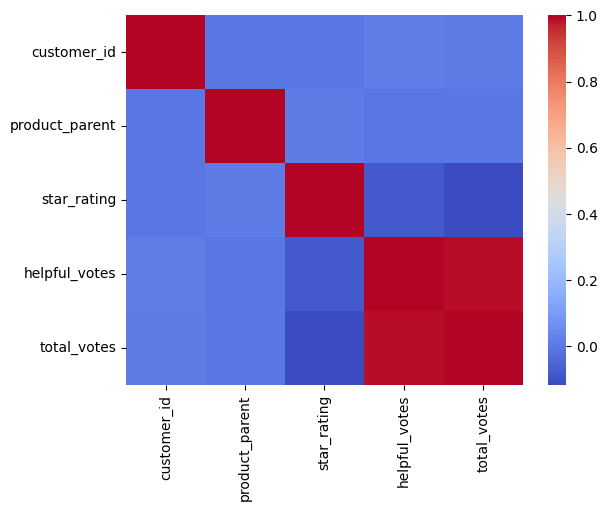

In [ ]:
#Heat map
print(df.corr())
import seaborn as sns
sns.heatmap(df.corr(), cmap='coolwarm')
'''
-1: perfectly negative correlation
0: no correlation
1: perfect correlation

'''

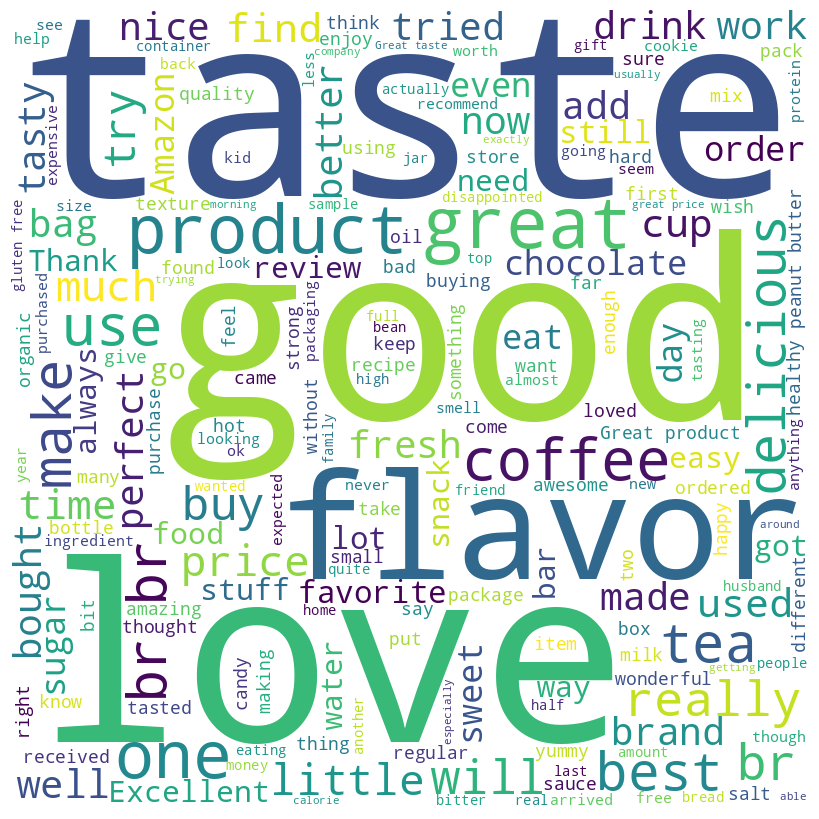

In [ ]:
# Combine all review text into a single string
reviews = ' '.join(df['review_body'].dropna().tolist())
# Generate a wordcloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(reviews)
# Display the wordcloud
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

'\nThe VADER tool calculates four scores: positive, negative, neutral, and compound, with the compound score being a normalized weighted composite score that ranges from -1 (most negative) to +1 (most positive).\nThe histogram of the sentiment scores can provide insight into the overall sentiment of the reviews. If the distribution of sentiment scores is skewed towards positive values, it indicates that the reviews are generally positive in sentiment. Conversely, if the distribution is skewed towards negative values, it indicates that the reviews are generally negative in sentiment. \n'

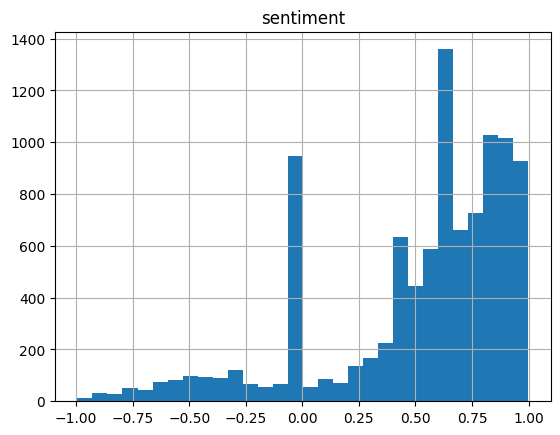

In [ ]:
# Create a SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()
# Calculate the sentiment scores for each review
df['review_body'].dropna(inplace=True)
df['sentiment'] = df['review_body'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
# Plot a histogram of the sentiment scores
df.hist(column='sentiment', bins=30)
'''
The VADER tool calculates four scores: positive, negative, neutral, and compound, with the compound score being a normalized weighted composite score that ranges from -1 (most negative) to +1 (most positive).
The histogram of the sentiment scores can provide insight into the overall sentiment of the reviews. If the distribution of sentiment scores is skewed towards positive values, it indicates that the reviews are generally positive in sentiment. Conversely, if the distribution is skewed towards negative values, it indicates that the reviews are generally negative in sentiment. 
'''

In [ ]:
# Tokenize the review text
tokenized_reviews = [simple_preprocess(review) for review in df['review_body'].dropna()]

# Create a dictionary of the tokens
dictionary = Dictionary(tokenized_reviews)

# Convert the tokenized reviews into bag-of-words vectors
corpus = [dictionary.doc2bow(review) for review in tokenized_reviews]

# Train an LDA model on the corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)

# Print the top words in each topic
for topic in lda_model.print_topics():
    print(topic)

(0, '0.034*"excellent" + 0.024*"yummy" + 0.019*"the" + 0.018*"and" + 0.016*"these" + 0.013*"seasoning" + 0.012*"it" + 0.011*"my" + 0.011*"too" + 0.011*"wonderful"')
(1, '0.113*"great" + 0.039*"product" + 0.039*"good" + 0.034*"it" + 0.030*"love" + 0.027*"and" + 0.023*"taste" + 0.022*"as" + 0.022*"price" + 0.015*"this"')
(2, '0.045*"and" + 0.033*"the" + 0.033*"good" + 0.028*"these" + 0.027*"to" + 0.026*"of" + 0.025*"are" + 0.022*"very" + 0.022*"bars" + 0.020*"they"')
(3, '0.028*"the" + 0.027*"this" + 0.026*"to" + 0.021*"love" + 0.019*"good" + 0.018*"stuff" + 0.017*"in" + 0.014*"my" + 0.014*"store" + 0.013*"find"')
(4, '0.027*"the" + 0.025*"to" + 0.022*"of" + 0.022*"it" + 0.020*"and" + 0.017*"that" + 0.016*"this" + 0.015*"you" + 0.014*"is" + 0.011*"but"')
(5, '0.060*"the" + 0.037*"and" + 0.026*"to" + 0.025*"it" + 0.020*"this" + 0.020*"was" + 0.019*"in" + 0.016*"of" + 0.011*"is" + 0.010*"my"')
(6, '0.052*"the" + 0.027*"it" + 0.022*"of" + 0.022*"and" + 0.021*"is" + 0.019*"to" + 0.018*"you" 

In [ ]:
from gensim.models import CoherenceModel

# Compute coherence score for the trained LDA model
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)


Coherence Score: 0.4945521222899106


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   marketplace        10000 non-null  object 
 1   customer_id        10000 non-null  int64  
 2   review_id          10000 non-null  object 
 3   product_id         10000 non-null  object 
 4   product_parent     10000 non-null  int64  
 5   product_title      10000 non-null  object 
 6   product_category   10000 non-null  object 
 7   star_rating        10000 non-null  int64  
 8   helpful_votes      10000 non-null  float64
 9   total_votes        10000 non-null  float64
 10  vine               10000 non-null  object 
 11  verified_purchase  10000 non-null  object 
 12  review_headline    10000 non-null  object 
 13  review_body        9998 non-null   object 
 14  review_date        10000 non-null  object 
 15  sentiment          10000 non-null  float64
dtypes: float64(3), int64(3)

In [ ]:
ratings_count=df.star_rating.value_counts(sort=False)
ratings_count

5    7183
2     392
1     729
4    1147
3     549
Name: star_rating, dtype: int64

In [ ]:
print("Total number of Users   :", len(np.unique(df.customer_id)))
print("Total number of Products  :", len(np.unique(df.product_id)))

Total number of Users   : 7918
Total number of Products  : 7919


<Axes: ylabel='star_rating'>

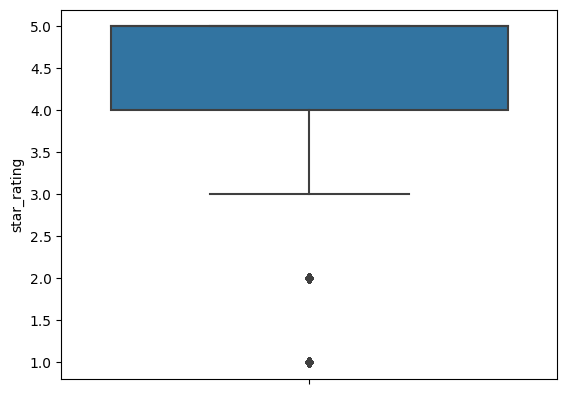

In [ ]:
sns.boxplot(y='star_rating',data=df)
#dots: outliers


In [ ]:
#Check the top 10 users based on ratings
df.drop_duplicates(inplace=True)
most_rated=df.groupby('customer_id').size().sort_values(ascending=False)
print('Top 10 users based on ratings: \n',most_rated[:10])

Top 10 users based on ratings: 
 customer_id
20674418    18
13403431    17
36290808    15
37599324    14
34247947    14
30716947    13
1383733     13
11375470    13
12046133    12
1535682     12
dtype: int64


In [ ]:
counts=df.customer_id.value_counts()
df1_final=df[df.customer_id.isin(counts[counts>=5].index)]
print('Number of users who have rated 10 or more items =', len(df1_final))
print('Number of unique users in the final data = ', df1_final['customer_id'].nunique())
print('Number of unique products in the final data = ', df1_final['product_id'].nunique())

Number of users who have rated 10 or more items = 774
Number of unique users in the final data =  116
Number of unique products in the final data =  748


In [ ]:
df.head()


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,42521656,R26MV8D0KG6QI6,B000SAQCWC,159713740,"The Cravings Place Chocolate Chunk Cookie Mix,...",Grocery,5,0.0,0.0,N,Y,Using these for years - love them.,"As a family allergic to wheat, dairy, eggs, nu...",2015-08-31,0.8096
1,US,12049833,R1OF8GP57AQ1A0,B00509LVIQ,138680402,"Mauna Loa Macadamias, 11 Ounce Packages",Grocery,5,0.0,0.0,N,Y,Wonderful,"My favorite nut. Creamy, crunchy, salty, and ...",2015-08-31,0.6915
2,US,107642,R3VDC1QB6MC4ZZ,B00KHXESLC,252021703,Organic Matcha Green Tea Powder - 100% Pure Ma...,Grocery,5,0.0,0.0,N,N,Five Stars,This green tea tastes so good! My girlfriend l...,2015-08-31,0.8286
3,US,6042304,R12FA3DCF8F9ER,B000F8JIIC,752728342,15oz Raspberry Lyons Designer Dessert Syrup Sauce,Grocery,5,0.0,0.0,N,Y,Five Stars,I love Melissa's brand but this is a great sec...,2015-08-31,0.8500
4,US,18123821,RTWHVNV6X4CNJ,B004ZWR9RQ,552138758,"Stride Spark Kinetic Fruit Sugar Free Gum, 14-...",Grocery,5,0.0,0.0,N,Y,Five Stars,good,2015-08-31,0.4404


#**Preprocessing**


In [ ]:
df.drop(['marketplace','vine', 'verified_purchase'], axis=1)

,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,review_headline,review_body,review_date,sentiment
0,42521656,R26MV8D0KG6QI6,B000SAQCWC,159713740,"[craving, place, chocolate, chunk, cookie, mix...",Grocery,5,0.0,0.0,Using these for years - love them.,"[family, allergic, wheat, dairy, egg, nut, sev...",2015-08-31,0.8096
1,12049833,R1OF8GP57AQ1A0,B00509LVIQ,138680402,"[mauna, loa, macadamia, 11, ounce, package]",Grocery,5,0.0,0.0,Wonderful,"[favorite, nut, creamy, crunchy, salty, slight...",2015-08-31,0.6915
2,107642,R3VDC1QB6MC4ZZ,B00KHXESLC,252021703,"[organic, matcha, green, tea, powder, 100, pur...",Grocery,5,0.0,0.0,Five Stars,"[green, tea, taste, good, girlfriend, love]",2015-08-31,0.8286
3,6042304,R12FA3DCF8F9ER,B000F8JIIC,752728342,"[15oz, raspberry, lyon, designer, dessert, syr...",Grocery,5,0.0,0.0,Five Stars,"[love, melissa, brand, great, second, cant, ge...",2015-08-31,0.8500
4,18123821,RTWHVNV6X4CNJ,B004ZWR9RQ,552138758,"[stride, spark, kinetic, fruit, sugar, free, g...",Grocery,5,0.0,0.0,Five Stars,[good],2015-08-31,0.4404
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,18423497,R1AYN0EGNZY898,B003Q3EYVO,946201884,"[farmdirect, 100, kona, coffee, dark, roast, w...",Grocery,5,0.0,0.0,Five Stars,"[love, medium, dark, roast, always, happy, blu...",2015-08-28,0.8360
9996,15676025,RP1U62EKOFMOT,B004D03WCG,695987685,"[stonewall, kitchen, sauce]",Grocery,5,0.0,0.0,Choca-holics rejoice! Love this stuff!,"[always, top, line, chocolate, sauce, oh, remi...",2015-08-28,0.9022
9997,19638218,R1MVDG6C173V3C,B004FEGLLO,493740672,"[hawaiian, punch, berry, blue, typhoon, 128oun...",Grocery,5,0.0,0.0,Five Stars,"[thanks, good, item]",2015-08-28,0.7003
9998,51274903,R2O1TZ2JXWXDE6,B004B7C524,873009722,"[provence, epice, provence, herb, france, larg...",Grocery,4,0.0,0.0,Put it on NY Strip? You win!,"[salt, pepper, herbe, de, provence, ny, strip,...",2015-08-28,0.0000


In [ ]:
df = df.dropna(subset=['review_body','star_rating','product_title'])

In [ ]:
# Case Folding
df['review_body']=df['review_body'].str.lower()
df['product_title']=df['product_title'].str.lower()


In [ ]:
# Removing Punctuations:
df['review_body']=df['review_body'].str.replace(r'[^\w\s]+', '')
df['product_title']=df['product_title'].str.replace(r'[^\w\s]+', '')

<ipython-input-38-8ab4152a84fe>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_body']=df['review_body'].str.replace(r'[^\w\s]+', '')
<ipython-input-38-8ab4152a84fe>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['product_title']=df['product_title'].str.replace(r'[^\w\s]+', '')


In [ ]:
# Remove Whitespace
df['review_body']=df['review_body'].str.strip()
df['product_title']=df['product_title'].str.strip()

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#df['review_body'] = df.apply(lambda row: nltk.word_tokenize(row['review_body']), axis=1)
df["review_body"]=list(map(word_tokenize, df["review_body"]))
df["product_title"]=list(map(word_tokenize, df["product_title"]))

In [ ]:
# Remove Stopwords

stop = stopwords.words('english')
def remove_stopwords(text):
    output= [i for i in text if i not in stop]
    return output

df['review_body']= df['review_body'].apply(lambda x:remove_stopwords(x))
df['product_title']= df['product_title'].apply(lambda x:remove_stopwords(x))

In [ ]:
df['product_title']

0       [cravings, place, chocolate, chunk, cookie, mi...
1           [mauna, loa, macadamias, 11, ounce, packages]
2       [organic, matcha, green, tea, powder, 100, pur...
3       [15oz, raspberry, lyons, designer, dessert, sy...
4       [stride, spark, kinetic, fruit, sugar, free, g...
                              ...                        
9995    [farmdirect, 100, kona, coffee, dark, roast, w...
9996                          [stonewall, kitchen, sauce]
9997    [hawaiian, punch, berry, blue, typhoon, 128oun...
9998    [provence, epice, provence, herbs, france, lar...
9999                 [body, parts, gummy, candy, 3, pack]
Name: product_title, Length: 9998, dtype: object

In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(word) for word in text]

df['review_body'] =df['review_body'].apply(lambda x:lemmatize_text(x))
df['product_title'] =df['product_title'].apply(lambda x:lemmatize_text(x))

In [ ]:
df


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,42521656,R26MV8D0KG6QI6,B000SAQCWC,159713740,"[craving, place, chocolate, chunk, cookie, mix...",Grocery,5,0.0,0.0,N,Y,Using these for years - love them.,"[family, allergic, wheat, dairy, egg, nut, sev...",2015-08-31,0.8096
1,US,12049833,R1OF8GP57AQ1A0,B00509LVIQ,138680402,"[mauna, loa, macadamia, 11, ounce, package]",Grocery,5,0.0,0.0,N,Y,Wonderful,"[favorite, nut, creamy, crunchy, salty, slight...",2015-08-31,0.6915
2,US,107642,R3VDC1QB6MC4ZZ,B00KHXESLC,252021703,"[organic, matcha, green, tea, powder, 100, pur...",Grocery,5,0.0,0.0,N,N,Five Stars,"[green, tea, taste, good, girlfriend, love]",2015-08-31,0.8286
3,US,6042304,R12FA3DCF8F9ER,B000F8JIIC,752728342,"[15oz, raspberry, lyon, designer, dessert, syr...",Grocery,5,0.0,0.0,N,Y,Five Stars,"[love, melissa, brand, great, second, cant, ge...",2015-08-31,0.8500
4,US,18123821,RTWHVNV6X4CNJ,B004ZWR9RQ,552138758,"[stride, spark, kinetic, fruit, sugar, free, g...",Grocery,5,0.0,0.0,N,Y,Five Stars,[good],2015-08-31,0.4404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,US,18423497,R1AYN0EGNZY898,B003Q3EYVO,946201884,"[farmdirect, 100, kona, coffee, dark, roast, w...",Grocery,5,0.0,0.0,N,Y,Five Stars,"[love, medium, dark, roast, always, happy, blu...",2015-08-28,0.8360
9996,US,15676025,RP1U62EKOFMOT,B004D03WCG,695987685,"[stonewall, kitchen, sauce]",Grocery,5,0.0,0.0,N,Y,Choca-holics rejoice! Love this stuff!,"[always, top, line, chocolate, sauce, oh, remi...",2015-08-28,0.9022
9997,US,19638218,R1MVDG6C173V3C,B004FEGLLO,493740672,"[hawaiian, punch, berry, blue, typhoon, 128oun...",Grocery,5,0.0,0.0,N,Y,Five Stars,"[thanks, good, item]",2015-08-28,0.7003
9998,US,51274903,R2O1TZ2JXWXDE6,B004B7C524,873009722,"[provence, epice, provence, herb, france, larg...",Grocery,4,0.0,0.0,N,Y,Put it on NY Strip? You win!,"[salt, pepper, herbe, de, provence, ny, strip,...",2015-08-28,0.0000


#**Negihborhood based Collabarative Filtering**

#1) Memory/Neighbourhood Based Collabarative Filtering

In [ ]:
user_item_matrix = df.pivot_table(index='customer_id', columns='product_id', values='star_rating')
#index, column, value

In [ ]:
user_item_matrix

product_id,3334353648,4639725418,B0000531B7,B000063D0C,B00006IUTN,B00008CQRK,B0000CCZYT,B0000CDBPT,B0000CEQ6H,B0000CERYV,...,B013YH1POU,B013Z565IC,B0140324OW,B0141KONH0,B0142KDXRU,B0143M04XI,B014537Q6S,B014692KFS,B014E26EPO,B014I1QPLE
customer_id,,,,,,,,,,,,,,,,,,,,,
19877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53081331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53089262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53090839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
user_item_matrix.to_csv("C:\\Users\\HP\\Downloads\\export.csv")

In [ ]:
import sys
f = open("matrix.csv","w")
user_item_matrix.to_csv(f, index=False)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
user_similarity = cosine_similarity(user_item_matrix.fillna(0))

In [ ]:
def get_similar_users(user_id, n=10):
    user_index = user_item_matrix.index.get_loc(user_id)
    similar_users = sorted(list(enumerate(user_similarity[user_index])), key=lambda x: x[1], reverse=True)
    return [user_item_matrix.index[user] for user, score in similar_users[1:n+1]]

In [ ]:
get_similar_users(42521656)

[19877, 20519, 22475, 37119, 41717, 43023, 44205, 48408, 49188, 63835]

In [ ]:
def get_similar_users2(user_id, n=10):
    user_index = user_item_matrix.index.get_loc(user_id)
    similar_users = sorted(list(enumerate(user_similarity[user_index])), key=lambda x: x[1], reverse=True)
    return [(user_item_matrix.index[user],score) for user, score in similar_users[1:n+1]]

In [ ]:
get_similar_users2(42521656)

[(19877, 0.0),
 (20519, 0.0),
 (22475, 0.0),
 (37119, 0.0),
 (41717, 0.0),
 (43023, 0.0),
 (44205, 0.0),
 (48408, 0.0),
 (49188, 0.0),
 (63835, 0.0)]

In [ ]:
item_similarity = cosine_similarity(user_item_matrix.fillna(0).T)

In [ ]:
def get_similar_items(product_id, n=10):
    item_index = user_item_matrix.columns.get_loc(product_id)
    similar_items = sorted(list(enumerate(item_similarity[item_index])), key=lambda x: x[1], reverse=True)
    return [user_item_matrix.columns[item] for item, score in similar_items[1:n+1]]


In [ ]:
get_similar_items("B000SAQCWC")

['B000SARZ9Q',
 '3334353648',
 '4639725418',
 'B0000531B7',
 'B000063D0C',
 'B00006IUTN',
 'B00008CQRK',
 'B0000CCZYT',
 'B0000CDBPT',
 'B0000CEQ6H']

In [ ]:
pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from surprise import Dataset, Reader

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['customer_id', 'product_id', 'star_rating']], reader)

In [ ]:
from surprise import SVD, accuracy
from surprise.model_selection import cross_validate

In [ ]:
algo = SVD()

In [ ]:
algo.fit(data.build_full_trainset())

In [ ]:
def predict_rating(user_id, product_id):
    return algo.predict(user_id, product_id).est

In [ ]:
predict_rating(12650237,"B0083GJKR2")

3.8991448704717184

In [ ]:
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2136  1.1526  1.2188  1.2358  1.1316  1.1905  0.0407  
MAE (testset)     0.9038  0.8662  0.9021  0.9094  0.8560  0.8875  0.0219  
Fit time          0.39    0.38    0.37    0.37    0.37    0.37    0.01    
Test time         0.02    0.02    0.02    0.02    0.03    0.02    0.00    


{'test_rmse': array([1.21355095, 1.15263654, 1.21875641, 1.23576279, 1.13162261]),
 'test_mae': array([0.9037556 , 0.8662225 , 0.90213998, 0.90944096, 0.85596296]),
 'fit_time': (0.38910889625549316,
  0.3776881694793701,
  0.3652205467224121,
  0.3718736171722412,
  0.36589860916137695),
 'test_time': (0.020676612854003906,
  0.02268838882446289,
  0.021547317504882812,
  0.0221707820892334,
  0.02752852439880371)}

#**Knowledge based Recommendation**

In [ ]:
df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,42521656,R26MV8D0KG6QI6,B000SAQCWC,159713740,"[craving, place, chocolate, chunk, cookie, mix...",Grocery,5,0.0,0.0,N,Y,Using these for years - love them.,"[family, allergic, wheat, dairy, egg, nut, sev...",2015-08-31,0.8096
1,US,12049833,R1OF8GP57AQ1A0,B00509LVIQ,138680402,"[mauna, loa, macadamia, 11, ounce, package]",Grocery,5,0.0,0.0,N,Y,Wonderful,"[favorite, nut, creamy, crunchy, salty, slight...",2015-08-31,0.6915
2,US,107642,R3VDC1QB6MC4ZZ,B00KHXESLC,252021703,"[organic, matcha, green, tea, powder, 100, pur...",Grocery,5,0.0,0.0,N,N,Five Stars,"[green, tea, taste, good, girlfriend, love]",2015-08-31,0.8286
3,US,6042304,R12FA3DCF8F9ER,B000F8JIIC,752728342,"[15oz, raspberry, lyon, designer, dessert, syr...",Grocery,5,0.0,0.0,N,Y,Five Stars,"[love, melissa, brand, great, second, cant, ge...",2015-08-31,0.8500
4,US,18123821,RTWHVNV6X4CNJ,B004ZWR9RQ,552138758,"[stride, spark, kinetic, fruit, sugar, free, g...",Grocery,5,0.0,0.0,N,Y,Five Stars,[good],2015-08-31,0.4404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,US,18423497,R1AYN0EGNZY898,B003Q3EYVO,946201884,"[farmdirect, 100, kona, coffee, dark, roast, w...",Grocery,5,0.0,0.0,N,Y,Five Stars,"[love, medium, dark, roast, always, happy, blu...",2015-08-28,0.8360
9996,US,15676025,RP1U62EKOFMOT,B004D03WCG,695987685,"[stonewall, kitchen, sauce]",Grocery,5,0.0,0.0,N,Y,Choca-holics rejoice! Love this stuff!,"[always, top, line, chocolate, sauce, oh, remi...",2015-08-28,0.9022
9997,US,19638218,R1MVDG6C173V3C,B004FEGLLO,493740672,"[hawaiian, punch, berry, blue, typhoon, 128oun...",Grocery,5,0.0,0.0,N,Y,Five Stars,"[thanks, good, item]",2015-08-28,0.7003
9998,US,51274903,R2O1TZ2JXWXDE6,B004B7C524,873009722,"[provence, epice, provence, herb, france, larg...",Grocery,4,0.0,0.0,N,Y,Put it on NY Strip? You win!,"[salt, pepper, herbe, de, provence, ny, strip,...",2015-08-28,0.0000


In [ ]:
import re
def clean_text(text):
    text = re.sub('<.*?>', ' ', text)
    text = re.sub('[^a-zA-Z0-9]+', ' ', text)
    text=text.lower()
    text =text.split()
    text=remove_stopwords(text)
    text =lemmatize_text(text)
    return text

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
mlb = MultiLabelBinarizer()
product_encoded = mlb.fit_transform(df['product_title'])
product_similarity = cosine_similarity(product_encoded) #contains pairwise similarity scores

In [ ]:
print(product_encoded)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
def get_similar_products(product_id, n=10):
    product_index = df.index[df['product_id'] == product_id].tolist()[0]
    similar_products = sorted(list(enumerate(product_similarity[product_index])), key=lambda x: x[1], reverse=True)
    return df.iloc[[i for i, _ in similar_products[1:n+1]]]


In [ ]:
# Find 10 products similar to given product_id
similar_products = get_similar_products('B000SAQCWC')
print(similar_products[["product_id","product_title"]])

      product_id                                      product_title
838   B000SARZ9Q  [craving, place, ooey, gooey, chocolatey, chew...
4263  B004AXZ5I0                    [mix, batter, tempura, pack, 6]
5483  B00OU25KVI  [cotton, mouth, candy, sour, mix, bag, 33oz, 6...
1058  B000H28ADK  [caffe, dvita, white, chocolate, cappuccino, m...
712   B000UV6WJM  [preformed, frozen, cookie, dough, chocolate, ...
4240  B000EDBQ4M       [gluten, free, chocolate, chip, cookie, mix]
3277  B00HWB9NJE  [quest, variety, pack, craving, peanut, butter...
9120  B00O3GR6TK  [quest, nutrition, quest, bar, variety, pack, ...
124   B0019SE6M0                      [ghirardelli, chocolate, mix]
4392  B001G604YY                      [ghirardelli, chocolate, mix]


In [ ]:
def constraint_based_filter(keywords=None, min_rating=None, max_rating=None):
    filtered_products = df.copy()
    if keywords:
        keywords = clean_text(keywords)
        filtered_products = filtered_products[filtered_products['review_body'].apply(lambda x: any(kw in x for kw in keywords)) \
                                      | filtered_products['product_title'].apply(lambda x: any(kw in x for kw in keywords))]
    if min_rating:
        filtered_products = filtered_products[filtered_products['star_rating'] >= min_rating]
    if max_rating:
        filtered_products = filtered_products[filtered_products['star_rating'] <= max_rating]

    return filtered_products

In [ ]:
# Search for products with keywords and ratings range
filtered_products = constraint_based_filter(keywords='organic gluten free', min_rating=4, max_rating=5)
print(filtered_products[['product_id','product_title','review_body']])

      product_id                                      product_title  \
2     B00KHXESLC  [organic, matcha, green, tea, powder, 100, pur...   
4     B004ZWR9RQ  [stride, spark, kinetic, fruit, sugar, free, g...   
11    B007TGH4CK  [wholesome, sweetener, organic, coconut, palm,...   
14    B00V7LJIG8  [everly, passion, fruit, green, tea, natural, ...   
16    B00VK5SQOQ  [food, taste, good, real, good, bar, gluten, f...   
...          ...                                                ...   
9967  B00ZSPN2A2  [1, lb, organic, turmeric, root, powder, organ...   
9968  B0095FWPZE           [simply, organic, pepper, tin, 4, ounce]   
9974  B00SE3VPB8  [organic, matcha, green, tea, japan, ultraprem...   
9979  B00UHCSEG8                   [one, organic, roasted, seaweed]   
9983  B00H6T4XXS  [indus, organic, turkish, jumbo, dried, fig, s...   

                                            review_body  
2           [green, tea, taste, good, girlfriend, love]  
4                              

#**Content based Recommendation**

In [ ]:
relevant_df = df[['product_id', 'product_title', 'product_category']]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy)
tfidf_matrix = vectorizer.fit_transform(df['product_title'].values)

#vectorizer = TfidfVectorizer(preprocessor=preprocess)
#tfidf_matrix = vectorizer.fit_transform(relevant_df['product_title'].values)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
def create_user_profile(user_id, df, tfidf_matrix):
    # Filter the DataFrame to only include reviews from the given user
    user_reviews = df[df['customer_id'] == user_id]

    # Calculate the average rating given by the user
    avg_rating = user_reviews['star_rating'].mean()

    # Consider only the products that the user rated above their average rating
    liked_products = user_reviews[user_reviews['star_rating'] >= avg_rating]['product_id']

    # Get the indices of the liked products in the DataFrame
    liked_product_indices = df[df['product_id'].isin(liked_products)].index
    
    # Calculate the user profile as the average of the liked products' TF-IDF vectors
    user_profile = tfidf_matrix[liked_product_indices].mean(axis=0)

    return user_profile

In [ ]:
# Split the dataset into training and test sets
test_size = 0.2
train_df = df.sample(frac=1-test_size, random_state=42)
test_df = df.drop(train_df.index)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_items(user_id, df, tfidf_matrix, top_n=10):
    user_profile = create_user_profile(user_id, df, tfidf_matrix)
    user_profile = np.asarray(user_profile)
    cosine_sim = cosine_similarity(user_profile, tfidf_matrix)

    # Sort items by similarity and return the top N items
    sorted_indices = cosine_sim.argsort()[0][::-1]
    sorted_indices = [i for i in sorted_indices if cosine_sim[0][i] < 1][:top_n]

    #sorted_indices = cosine_sim.argsort()[0][::-1][:top_n]
    recommended_items = df.iloc[sorted_indices]
    recommended_items['cosine_sim'] = cosine_sim[0][sorted_indices]
    return recommended_items[['product_id','product_title','cosine_sim']]

In [ ]:
recommend_items(23649464,df,tfidf_matrix)

<ipython-input-79-0c7faa99796c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_items['cosine_sim'] = cosine_sim[0][sorted_indices]


,product_id,product_title,cosine_sim
1194,B00A5V30PG,"[herr, popcorn, cheeze, flavored, 1, oz, pack,...",0.665536
1077,B0018SPTMW,"[herr, potato, chip]",0.432704
970,B00016Q6EM,"[popcorn, salt, 16, oz]",0.293558
6707,B00FKBUSW4,"[starbucks, classic, hot, cocoa, 30, ounce]",0.284252
3397,B0029XEY26,"[mizithra, cheese, 1, lb]",0.264475
2869,B00M16OMZU,"[adoboloco, hot, sauce, gift, set, 3, 5oz, 1, ...",0.264132
98,B0064OLVFY,"[cheese, wax, 1, lb, red]",0.257051
2283,B00AFELOT2,"[red, cheese, wax, 1, pound]",0.255635
4966,B007RGGDQK,"[indomie, variety, pack, 1, case, 30, bag]",0.247922
5911,B004OV3VG6,"[kernel, season, kettle, corn, popcorn, season...",0.233157
